In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [2]:

img_size = (224, 224)

# Data Augmentation (commented out for comparison)
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size
batch_size = 32

# Specify the paths to your train, validation, and test data
train_dir = 'D:\\Splitted Curated X-Ray Dataset\\train'
val_dir = 'D:\\Splitted Curated X-Ray Dataset\\val'
test_dir = 'D:\\Splitted Curated X-Ray Dataset\\test'

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle = False
)

Found 7364 images belonging to 4 classes.
Found 920 images belonging to 4 classes.
Found 924 images belonging to 4 classes.


In [3]:
from sklearn.utils import class_weight
import numpy as np

class_counts = np.unique(train_generator.classes, return_counts=True)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Ubah array bobot menjadi dictionary
class_weights_dict = {class_label: weight for class_label, weight in zip(class_counts[0], class_weights)}

print(class_weights_dict)

{0: 1.7978515625, 1: 0.7037461773700305, 2: 0.7670833333333333, 3: 1.3904833836858006}


In [4]:
# Get class indices from the training generator
class_indices = train_generator.class_indices

# Count the number of images in each class
num_images_per_class_train = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_indices.keys()}

# Print the results
print("Number of images in each class for the training set:")
for class_name, num_images in num_images_per_class_train.items():
    print(f"{class_name}: {num_images} images")


Number of images in each class for the training set:
COVID-19: 1024 images
Normal: 2616 images
Pneumonia-Bacterial: 2400 images
Pneumonia-Viral: 1324 images


In [5]:
# Load the ResNet50V2 model with pretrained weights (excluding the top dense layers)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = models.Sequential()

# Add the ResNet50V2 base model
model.add(base_model)

# Flatten the output layer to 1 dimension
model.add(layers.Flatten())

# Add a fully connected layer with 256 hidden units, ReLU activation, and L2 regularization
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.01)))

# Add a dropout layer for regularization
model.add(layers.Dropout(0.5))

# Add the final output layer with 4 classes for classification
model.add(layers.Dense(4, activation='softmax'))

# Print the model summary
model.summary()

KeyboardInterrupt: 

In [ ]:
# Define the initial learning rate and the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Define the optimizer with the learning rate schedule
opt = optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model with the specified number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    # callbacks=[early_stop],
    class_weight=class_weights_dict
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50
230/230 [==============================] - 133s 565ms/step - loss: 2.1949 - accuracy: 0.7287 - val_loss: 0.4450 - val_accuracy: 0.8281
Epoch 2/50
230/230 [==============================] - 128s 556ms/step - loss: 0.4883 - accuracy: 0.7853 - val_loss: 0.4708 - val_accuracy: 0.8047
Epoch 3/50
230/230 [==============================] - 124s 538ms/step - loss: 0.4447 - accuracy: 0.8066 - val_loss: 0.4458 - val_accuracy: 0.8348
Epoch 4/50
230/230 [==============================] - 125s 544ms/step - loss: 0.4356 - accuracy: 0.8137 - val_loss: 0.4030 - val_accuracy: 0.8292
Epoch 5/50
230/230 [==============================] - 129s 562ms/step - loss: 0.3680 - accuracy: 0.8325 - val_loss: 0.3967 - val_accuracy: 0.8616
Epoch 6/50
230/230 [==============================] - 124s 539ms/step - loss: 0.3490 - accuracy: 0.8505 - val_loss: 0.3797 - val_accuracy: 0.8638
Epoch 7/50
230/230 [==============================] - 130s 566ms/step - loss: 0.3354 - accuracy: 0.8438 - val_loss: 0.3501 -

In [ ]:
from sklearn.metrics import classification_report

# Get predictions on the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_labels = tf.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_labels, digits=4))

924/924 [==============================] - 19s 20ms/step

Classification Report:
                     precision    recall  f1-score   support

           COVID-19     0.9844    0.9767    0.9805       129
             Normal     0.9726    0.9786    0.9756       327
Pneumonia-Bacterial     0.8759    0.7973    0.8348       301
    Pneumonia-Viral     0.6839    0.7904    0.7333       167

           accuracy                         0.8853       924
          macro avg     0.8792    0.8858    0.8811       924
       weighted avg     0.8906    0.8853    0.8866       924



924/924 [==============================] - 18s 20ms/step


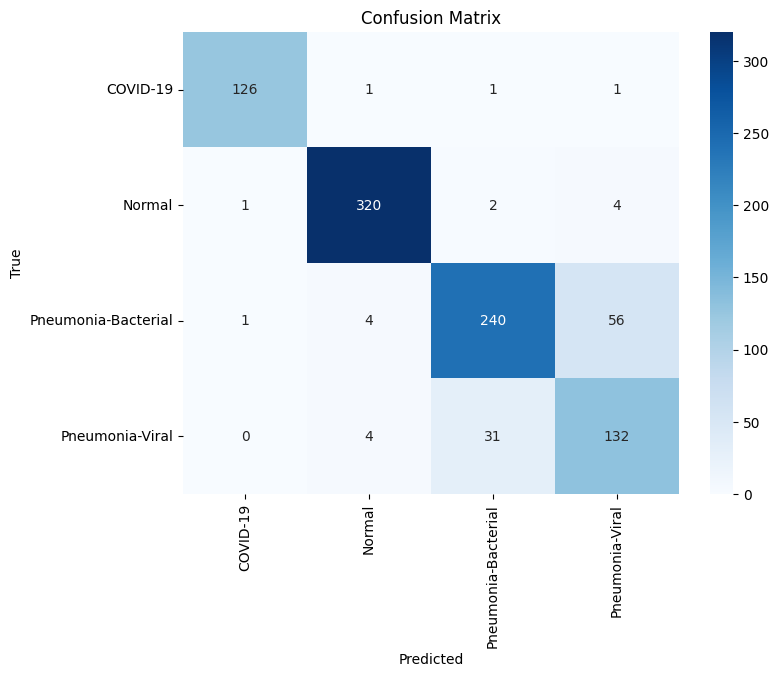

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict the classes for the test set
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Get the true classes for the test set
y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']  # Adjust these based on your actual class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


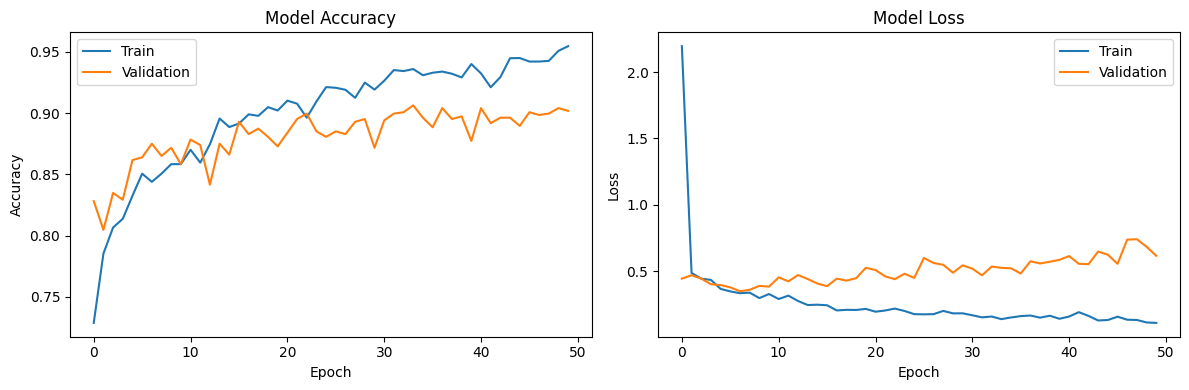

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming 'weighted_history' is the history object returned by model.fit()
plot_metrics(history)
